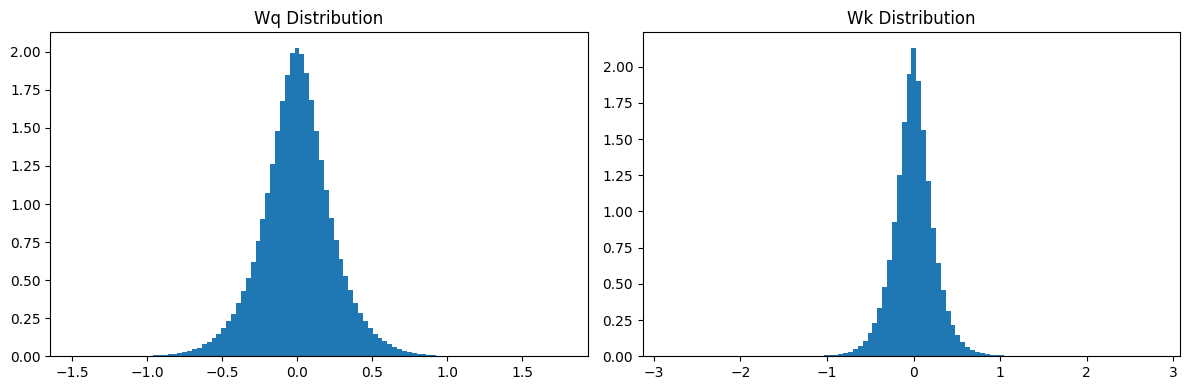

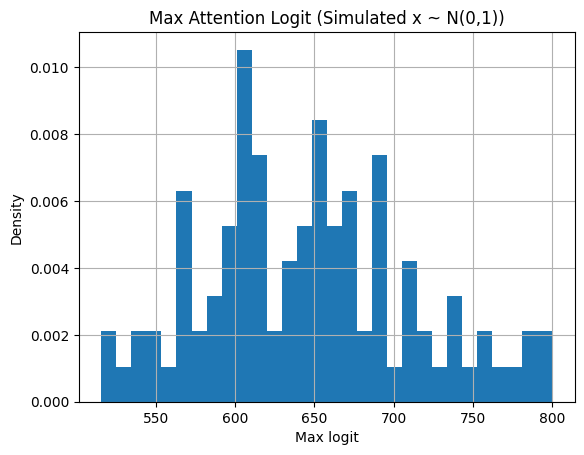

In [3]:
import torch
import matplotlib.pyplot as plt
from transformers import GPT2Model

# 모델 로딩 (첫 레이어만 사용)
model = GPT2Model.from_pretrained("gpt2")
model.eval()
layer = 0

attn = model.h[layer].attn
hidden = model.config.n_embd
num_heads = attn.num_heads
head_dim = hidden // num_heads

Wq = attn.c_attn.weight[:, :hidden].detach()
Wk = attn.c_attn.weight[:, hidden:2*hidden].detach()

# Wq, Wk 분포 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(Wq.cpu().numpy().flatten(), bins=100, density=True)
plt.title("Wq Distribution")

plt.subplot(1, 2, 2)
plt.hist(Wk.cpu().numpy().flatten(), bins=100, density=True)
plt.title("Wk Distribution")
plt.tight_layout()
plt.show()

# x ~ N(0,1) -> max(attn_logits) 분포 시뮬레이션
max_values = []
for _ in range(100):  # 더 늘릴 수 있음
    x = torch.randn(1, 10, hidden)  # [B, T, D]
    Q = x @ Wq
    K = x @ Wk
    Q = Q.view(1, 10, num_heads, head_dim).transpose(1, 2)  # [1, H, T, D]
    K = K.view(1, 10, num_heads, head_dim).transpose(1, 2)
    scores = Q @ K.transpose(-2, -1) / head_dim ** 0.5
    max_values.append(scores.max().item())

# 결과 시각화
plt.hist(max_values, bins=30, density=True)
plt.title("Max Attention Logit (Simulated x ~ N(0,1))")
plt.xlabel("Max logit")
plt.ylabel("Density")
plt.grid(True)
plt.show()


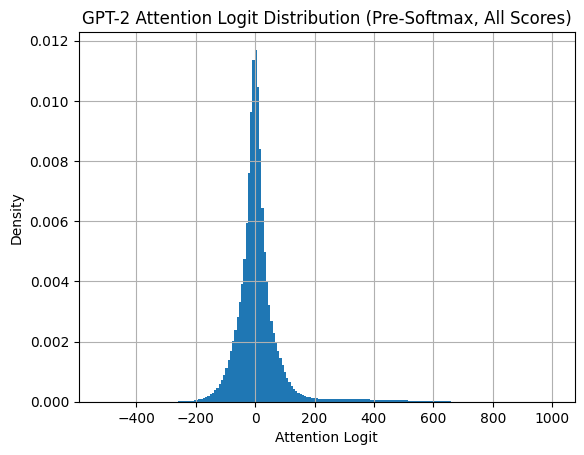

In [2]:
import torch
from transformers import GPT2Model
import matplotlib.pyplot as plt

# 1. GPT-2 모델 로드
model_name = "gpt2"
model = GPT2Model.from_pretrained(model_name)
model.eval()

# 2. LayerNorm 이후 입력 샘플링
def sample_normalized_x(seq_len, dim, batch_size):
    return torch.randn(batch_size, seq_len, dim)  # 평균 0, std 1 (LayerNorm 이후 가정)

# 3. 전체 Attention Score 추출
def get_attention_logits_all_gpt2(model, x, layer=0):
    attn = model.h[layer].attn  # GPT-2 attention module
    Wq = attn.c_attn.weight.data[:, :model.config.n_embd]  # Q
    Wk = attn.c_attn.weight.data[:, model.config.n_embd:2*model.config.n_embd]  # K

    # Q, K 계산
    Q = x @ Wq  # [B, T, D]
    K = x @ Wk  # [B, T, D]

    # Head 분리
    num_heads = attn.num_heads
    head_dim = model.config.n_embd // num_heads

    Q = Q.view(x.size(0), x.size(1), num_heads, head_dim).transpose(1, 2)  # [B, H, T, D]
    K = K.view(x.size(0), x.size(1), num_heads, head_dim).transpose(1, 2)  # [B, H, T, D]

    # Attention logits 계산
    attn_logits = Q @ K.transpose(-2, -1) / (head_dim ** 0.5)  # [B, H, T, T]

    return attn_logits.flatten().detach().cpu().numpy()  # 전체 분포 flatten

# 4. 분포 시각화
def simulate_and_plot_all_scores():
    seq_len = 10
    dim = model.config.n_embd
    batch_size = 64
    samples = []

    for _ in range(100):  # 반복 샘플링
        x = sample_normalized_x(seq_len, dim, batch_size)
        all_logits = get_attention_logits_all_gpt2(model, x, layer=0)
        samples.extend(all_logits)

    plt.hist(samples, bins=200, density=True)
    plt.title("GPT-2 Attention Logit Distribution (Pre-Softmax, All Scores)")
    plt.xlabel("Attention Logit")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

simulate_and_plot_all_scores()


In [4]:
from transformers import GPT2Model
model = GPT2Model.from_pretrained("gpt2")
Wq = model.h[0].attn.c_attn.weight[:, :768].flatten()
print(Wq.mean().item(), Wq.std().item())


0.0001537436037324369 0.2386905699968338
